In [ ]:
!pip install emcee
!pip install corner
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom,norm,uniform,multivariate_normal
import pandas as pd
import corner
import pymc3 as pm
from ipywidgets import *
from scipy.optimize import minimize
import emcee
%matplotlib inline

In [ ]:
#n es el número de pasos
#N es el número de caminantes
def pl(n,N):
  steps=n # de pasos
  nwalkers=N #número de caminos
  end=[(np.random.uniform(-1,1,steps)).sum() for i in range(nwalkers)] # llegada 

  plt.figure(figsize=(7,7))
  plt.subplot(3,1,1)
  plt.plot(end,'o')
  plt.subplot(3,1,2)
  sns.kdeplot(np.array(end),bw=0.1)
  plt.subplot(3,1,3)
  l=np.array([2,8,16])
  for k in range(N):
    where=np.zeros(n+1)
    c=0
    for i in range(1,n+1):
      c+=np.random.uniform(-1,1)
      where[i]+=c
    plt.plot(where,'b',alpha=0.2)
  for i in l:
      plt.axvline(i,color='darkred')
  plt.plot(where,c='k')
interact(pl,n=(1,16),N=(int(1e2),int(1e4)))

interactive(children=(IntSlider(value=8, description='n', max=16, min=1), IntSlider(value=5050, description='N…

<function __main__.pl>

Alturas vs pesos del archivo archivo  Howel1

In [ ]:
from google.colab import files
uploaded=files.upload()

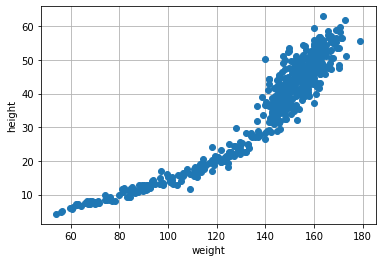

In [ ]:
Dat=np.loadtxt('Howell1.txt', comments='#',delimiter=';',skiprows=1)
height,weight,age,male=Dat[:,0],Dat[:,1],Dat[:,2],Dat[:,3]
plt.plot(height,weight, 'o')
plt.xlabel('weight')
plt.ylabel('height')
plt.grid()

Construimos muestras sinteticas para para sigma, y mu, usando unas distribucion uniforme y normal respectivamente, para los datos de alturas  para personas mayores de 18 años del archivo Howel1

In [ ]:
d=Dat[age>=18]
d1=d[:,1]
d2=d[:,0]

nsamp=10000 # numero de muestras 
sample_sigma=np.random.uniform(50,0,nsamp ) # Distribución uniforme para la desviación estandar
sample_mu=np.random.normal(178,20,nsamp) # distribución para la media

El dato previo de altura se puede crear usando una distribución normal para nuestras muestras sinteticas $normal(sample.mu,sample.sigma)$ 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


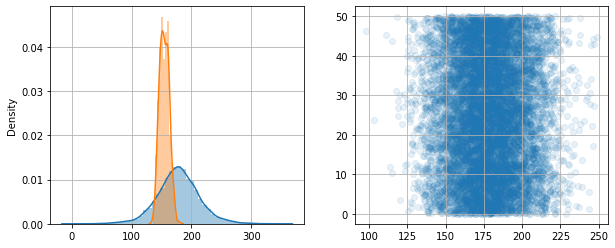

In [ ]:
prior_h=np.random.normal(sample_mu,sample_sigma)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(prior_h)
sns.distplot(d2)
plt.grid()
plt.subplot(1,2,2)
plt.scatter(sample_mu,sample_sigma,alpha=0.1)
plt.grid()

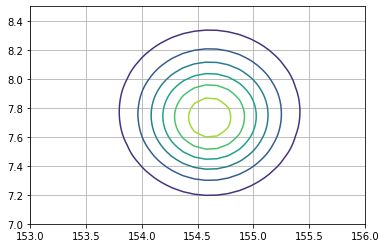

In [ ]:

mu_l=np.linspace(140,160,200) # arreglo para mu
sigma_l=np.linspace(4,9,200) # arreglo para sigma
mu,sigma=np.meshgrid(mu_l, sigma_l) # crenado una malla para el grafico 
log_like=np.sum([norm.logpdf(h,mu,sigma) for h in d2],axis=0) # Logaritmo de la probabilidad

log_priors=norm.logpdf(mu,178,20)+uniform.logpdf(sigma,0,50) #previa

log_post=log_like+log_priors # la  posterior en forma logaritmica
post=np.exp(log_post-log_post.max()) #posterior
plt.contour(mu,sigma,post) #Este grafico mustra el valor de la posterior como una grafica de contorno 
plt.xlim(153,156)
plt.ylim(7,8.5)
plt.grid()

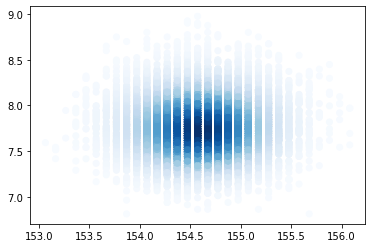

In [ ]:
p=(post/post.sum()).ravel()
draw_idx=np.random.choice(range(len(p)),replace=True, size=10000,  p=p)
mu_sample=mu.ravel()[draw_idx]
sigma_sample=sigma.ravel()[draw_idx]
plt.scatter(mu_sample,sigma_sample,c=p[draw_idx],cmap='Blues')

In [ ]:
y=(post/post.sum()).ravel()
y

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       8.07259163e-32, 8.18033702e-33, 7.93332494e-34])

#Modelo lineal para las alturas vs el peso

Suponemos que el modelo cumple una relacion lenal de la forma $\mu=ax+b$, donde $x$ son los pesos, de tal forma que 
$x-\mu(x)$, y la $y =N(\mu,\sigma)$

In [ ]:
#pesos
weight_c=d1-d1.mean()

# Funcion map
with pm.Model() as pred_model:
    a=pm.Normal('a',mu=156,sd=100)
    b=pm.Normal('b',mu=0,sd=10)
    mu=a+b*(weight_c)
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2)
    trace_pred = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]
100%|██████████| 2000/2000 [00:01<00:00, 1197.11it/s]


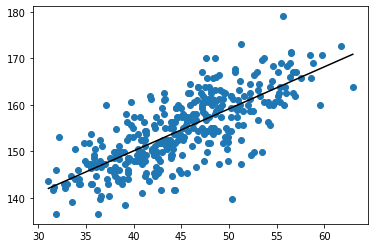

In [ ]:

filt=[np.logical_not('_interval__' in k) for k in trace_pred.varnames]
vnames=np.array(trace_pred.varnames)[filt]
trace_array=np.array([trace_pred[i] for i in vnames]).T
mean_pars=trace_array.mean(axis=0) # retorna los valores que tienen la maxima probilidad

plt.scatter(d[:,1],d2)
x=np.linspace(weight_c.min(),weight_c.max(),3)
plt.plot(x+d[:,1].mean(),mean_pars[0]+(x)*mean_pars[1],c='k')

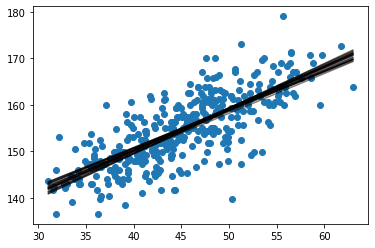

In [ ]:
mean_pars=trace_array.mean(axis=0)
plt.scatter(d[:,1],d2)
x=np.linspace(weight_c.min(),weight_c.max(),3)
plt.plot(x+d[:,1].mean(),mean_pars[0]+(x)*mean_pars[1],c='r')
for a,b,s in trace_array[np.random.randint(len(trace_array), size=20)]:
    plt.plot(x+d[:,1].mean(),a+x*b , color="k", alpha=0.5)
plt.show()

In [ ]:
x

array([-13.91943352,   2.04133498,  18.00210348])

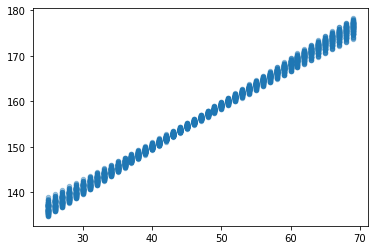

In [ ]:

nsamps=100
x=np.arange(25,70)
w_mn=d[:,1].mean()
dist_mu=np.array([a+b*(x-w_mn) for a,b,c in trace_array[:nsamps]]).T.ravel()
weights=np.array([nsamps*[i] for i in x]).ravel()
plt.scatter(weights,dist_mu,s=20,alpha=0.4)


#Modelo polinomial para las alturas vs el peso
 para este modelo se usa el mismo procedimeinto anterior, solo que en esta ocacion se tiene que un ajuste polinomial dado por $\mu =a+b_1x+b_2x^2+....+b_nx^n$, el resto del codigo es el mismo 

In [ ]:
d1=Dat[:,1]
d2=Dat[:,0]
regw=(d1-d1.mean())/d1.std()


with pm.Model() as pred_model:
    a=pm.Normal('a',mu=178,sd=100)
    b1=pm.Normal('b1',mu=0,sd=10)
    b2=pm.Normal('b2',mu=0,sd=10)
    b3=pm.Normal('b3',mu=0,sd=10)
    mu=pm.Deterministic('mu',a+b1*regw+b2*regw**2+b3*regw**3)
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    height=pm.Normal('height',mu=mu,sd=sigma,observed=d2)
    trace_pred=pm.sample(1000,tune=1000)
filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
vnames=np.array(trace_pred.varnames)[filt1&filt2]
trace_array_3=np.array([trace_pred[i] for i in vnames]).T

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b3, b2, b1, a]
100%|██████████| 2000/2000 [00:04<00:00, 400.51it/s]


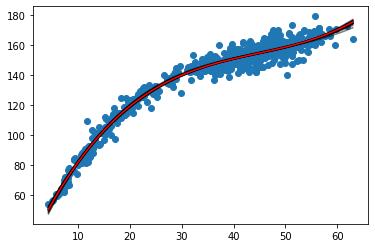

In [ ]:
x=np.linspace(regw.min(),regw.max(),100)
mean_pars=trace_array_3.mean(axis=0) # parametros del modelo
plt.scatter(d1,d2)

for a,b1,b2,b3,s in trace_array_3[np.random.randint(len(trace_array_3), size=20)]:
    plt.plot(x*d1.std()+d1.mean(),a+b1*x+b2*x**2+b3*x**3,color="k",alpha=0.5)
plt.plot(x*d1.std()+d1.mean(),mean_pars[0]+(x)*mean_pars[1]+(x**2)*mean_pars[2]+(x**3)*mean_pars[3],c='r')
plt.show()

Grafico de esquina 

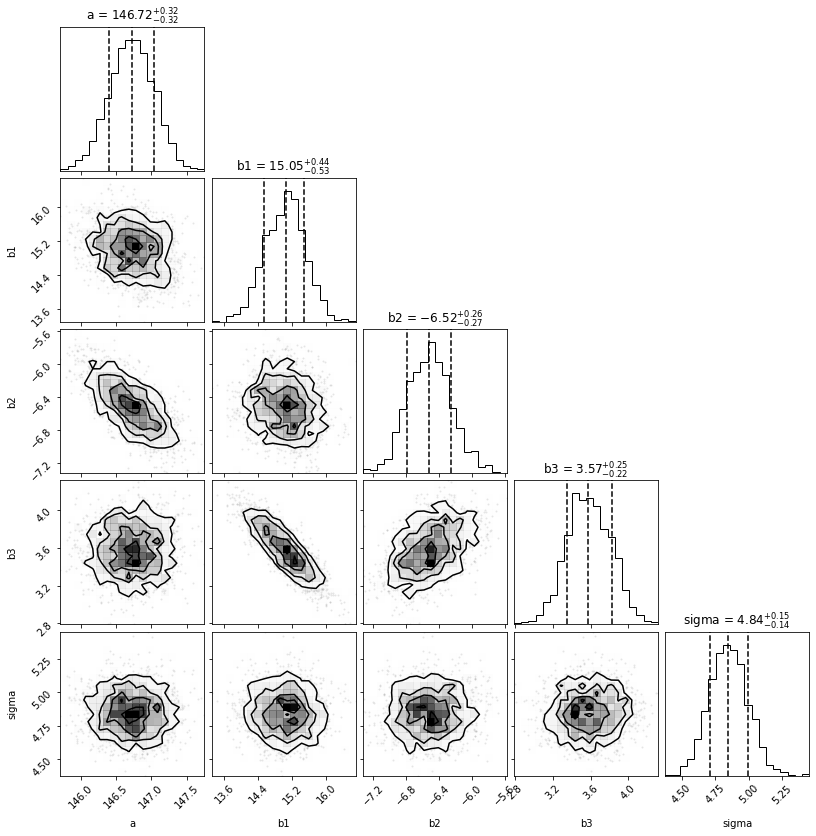

In [ ]:

filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
vnames=np.array(trace_pred.varnames)[filt1&filt2]
trace_array_2=np.array([trace_pred[i] for i in vnames]).T
corner.corner(trace_array_2,labels=vnames,quantiles=[0.16, 0.5, 0.84],show_titles=True) 
plt.show()

https://loco.lab.asu.edu/edges/edges-data-release/